# 3D U-Net for Volume Segmentation (TensorFlow / Keras)

This notebook trains a **3D U-Net** to segment volumetric data (e.g., medical CT/MRI or geological core samples).  

It includes:
- Reproducible setup and environment capture
- Data loading and **patchify → unpatchify** workflow
- Configurable model creation with **segmentation-models-3D**
- Robust training
- Clear visualizations of training curves and qualitative predictions

## 1. Environment

Install the required packages.

In [1]:
!pip install classification-models-3D
!pip install efficientnet-3D
!pip install segmentation-models-3D

In [2]:
!pip install patchify

## Import the required Libraries

In [3]:
import tensorflow as tf
import keras

In [4]:
import segmentation_models_3D as sm

Segmentation Models: using `keras` framework.


In [5]:
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

## 3. Import the data and Patchify the Volumes

Update these paths to point to your **3D volumes** and **ground-truth masks**.  
Supported formats include TIFF stacks (`.tif`), NIfTI (`.nii/.nii.gz`), and other array-like volumes you can load into NumPy.

Many 3D models train on patches to fit into GPU memory. We use cubic patches (e.g., 64×64×64).


In [6]:
# === EDIT THESE PATHS ===

image = io.imread('/content/drive/MyDrive/sandstone_data_for_ML/sandstone_data_for_ML/data_for_3D_Unet/train_images_256_256_256.tif')
img_patches = patchify(image, (64,64,64), step=64)

mask = io.imread('/content/drive/MyDrive/sandstone_data_for_ML/sandstone_data_for_ML/data_for_3D_Unet/train_masks_256_256_256.tif')
mask_patches = patchify(mask, (64,64,64), step=64)

In [7]:
print(img_patches.shape)

(4, 4, 4, 64, 64, 64)


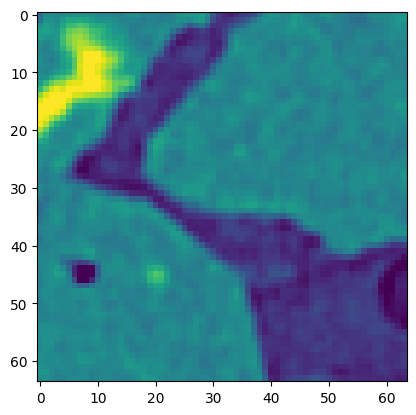

In [8]:
plt.imshow(img_patches[1,2,3,:,:,32])

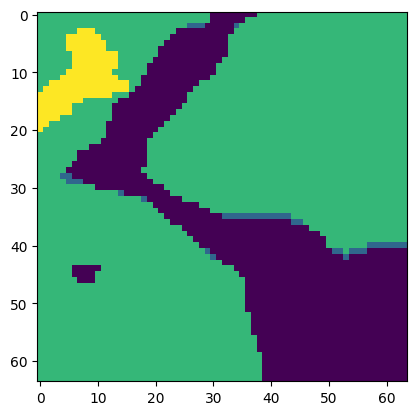

In [9]:
plt.imshow(mask_patches[1,2,3,:,:,32])

In [10]:
input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

In [11]:
input_img.shape

(64, 64, 64, 64)

In [12]:
input_mask.shape

(64, 64, 64, 64)

In [13]:
n_classes = 4

In [14]:
train_img = np.stack((input_img)*3, axis=1)
train_mask = np.expand_dims(input_mask, axis=4)
print(train_img.shape)
print(train_mask.shape)

(64, 64, 64, 64)
(64, 64, 64, 64, 1)


In [15]:
train_mask_cat = to_categorical(train_mask, num_classes=n_classes)

In [16]:
train_mask_cat.shape

(64, 64, 64, 64, 4)

In [17]:
train_mask_cat

array([[[[[0., 0., 1., 0.],
          [0., 0., 1., 0.],
          [0., 0., 1., 0.],
          ...,
          [0., 0., 0., 1.],
          [0., 0., 0., 1.],
          [0., 0., 0., 1.]],

         [[0., 0., 1., 0.],
          [0., 0., 1., 0.],
          [0., 0., 1., 0.],
          ...,
          [0., 0., 0., 1.],
          [0., 0., 0., 1.],
          [0., 0., 0., 1.]],

         [[0., 0., 1., 0.],
          [0., 0., 1., 0.],
          [0., 0., 1., 0.],
          ...,
          [0., 0., 0., 1.],
          [0., 0., 0., 1.],
          [0., 0., 0., 1.]],

         ...,

         [[0., 0., 1., 0.],
          [0., 0., 1., 0.],
          [0., 0., 1., 0.],
          ...,
          [0., 0., 0., 1.],
          [0., 0., 0., 1.],
          [0., 0., 0., 1.]],

         [[0., 0., 1., 0.],
          [0., 0., 1., 0.],
          [0., 0., 1., 0.],
          ...,
          [0., 0., 0., 1.],
          [0., 0., 0., 1.],
          [0., 0., 0., 1.]],

         [[0., 0., 1., 0.],
          [0., 0., 1., 0.],
    

##4. Train Test Split

We split the dataset into **training** and **testing** sets, reserving **10% of the data for testing** to evaluate model performance on unseen samples.


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(train_img, train_mask_cat, test_size=0.10, random_state=42)

In [19]:
X_train.shape

(57, 64, 64, 64)

## 5. Model: 3D U-Net (segmentation-models-3D)

In [20]:
# Loss Function and coefficient
def dice_coefficient(y_true,y_pred):
  smoothing_factor = 1
  flat_y_true = K.flatten(y_true)
  flat_y_pred = K.flatten(y_pred)
  return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred))

def dice_coefficient_loss(y_true,y_pred):
  return 1 - dice_coefficient(y_true, y_pred)

In [21]:
import segmentation_models_3D as sm3d
from tensorflow import keras
import numpy as np

# Parameters
BACKBONE = 'resnet18'       # valid 3D-adaptable backbone
encoder_weights = None       # pretrained 2D weights are not compatible with 3D
activation = 'softmax'
patch_size = 64
n_classes = 4
channels = 1
LR = 0.0001

# Optimizer
optim = keras.optimizers.Adam(LR)

# Losses and metrics
dice_loss = sm3d.losses.DiceLoss(class_weights=np.array([0.25]*n_classes))
focal_loss = sm3d.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss
metrics = [sm3d.metrics.IOUScore(threshold=0.5)]

In [22]:
# Convert to float32 and normalize to [0, 1]
X_train = X_train.astype('float32') / X_train.max()
X_test  = X_test.astype('float32') / X_test.max()

# Now shapes remain (57, 64, 64, 64, 1)
X_train_prep = X_train
X_test_prep  = X_test

In [23]:
import segmentation_models_3D as sm3d

# Define 3D U-Net
model = sm3d.Unet(
    backbone_name=BACKBONE,          # e.g., 'resnet3d18'
    encoder_weights=encoder_weights, # None for 3D backbones
    classes=n_classes,
    activation=activation,
    input_shape=(64, 64, 64, 1)      # depth, height, width, channels
)

# Compile the model
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

# Optional: check model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 64, 64,    │          0 │ -                 │
│                     │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 64, 64,    │          3 │ data[0][0]        │
│ (BatchNormalizatio… │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d      │ (None, 70, 70,    │          0 │ bn_data[0][0]     │
│ (ZeroPadding3D)     │ 70, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv3D)      │ (None, 32, 32,    │     21,952 │ zero_padding3d[0… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 32, 32,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 32, 32,    │          0 │ bn0[0][0]         │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d_1    │ (None, 34, 34,    │          0 │ relu0[0][0]       │
│ (ZeroPadding3D)     │ 34, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 16, 16,    │          0 │ zero_padding3d_1… │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 16, 16,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 16, 16,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d_2    │ (None, 18, 18,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding3D)     │ 18, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 16, 16,    │    110,592 │ zero_padding3d_2… │
│ (Conv3D)            │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 16, 16,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 16, 16,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d_3    │ (None, 18, 18,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding3D)     │ 18, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 16, 16,    │    110,592 │ zero_padding3d_3… │
│ (Conv3D)            │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 16, 16,    │      4,096 │ stage1_unit1_rel

 Total params: 42,624,775 (162.60 MB)

 Trainable params: 42,614,853 (162.56 MB)

 Non-trainable params: 9,922 (38.76 KB)

## 6. Training the model

In [25]:
# Train the model

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=8,
    epochs=100,
    shuffle=True
)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - iou_score: 0.0243 - loss: 1.0501 - val_iou_score: 0.0192 - val_loss: 1.8934
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step - iou_score: 0.0123 - loss: 1.0170 - val_iou_score: 0.0292 - val_loss: 1.8136
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 452ms/step - iou_score: 0.0083 - loss: 1.0013 - val_iou_score: 0.0276 - val_loss: 1.3292
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 479ms/step - iou_score: 0.0127 - loss: 0.9927 - val_iou_score: 0.0324 - val_loss: 1.2507
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 477ms/step - iou_score: 0.0215 - loss: 0.9850 - val_iou_score: 0.0072 - val_loss: 1.0356
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 480ms/step - iou_score: 0.0479 - loss: 0.9781 - val_iou_score: 2.6990e-04 - val_loss: 0.9946
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - iou_score: 0.0804 - loss: 0.9734 - val_iou_score: 0.0016 - val_loss: 0.9871
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 459ms/step - iou_score: 0.1225 - loss: 0.9677 - val_iou

## 8. Training Curves

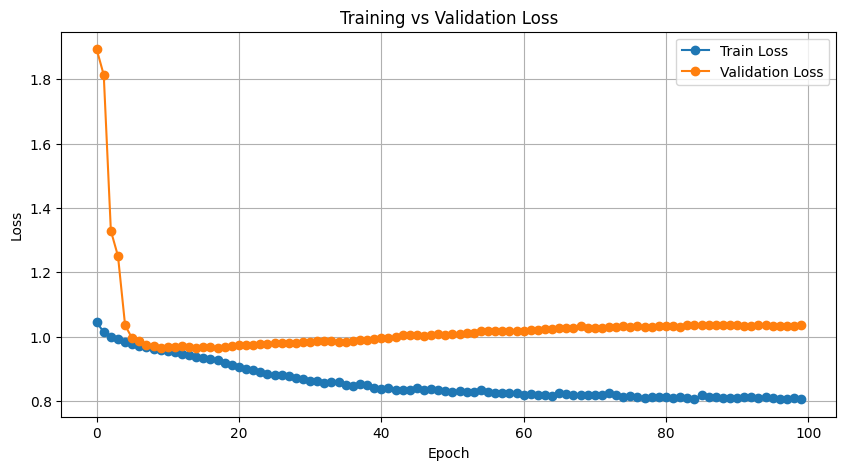

In [26]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

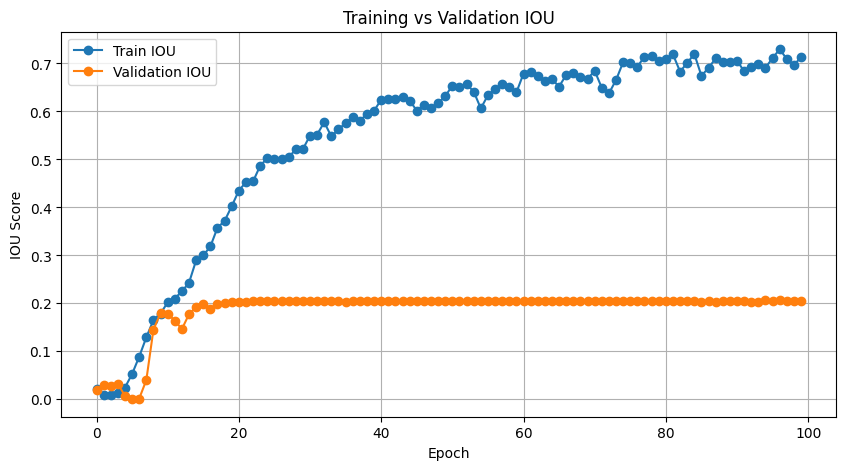

In [27]:
plt.figure(figsize=(10,5))
plt.plot(history.history['iou_score'], label='Train IOU', marker='o')
plt.plot(history.history['val_iou_score'], label='Validation IOU', marker='o')
plt.title('Training vs Validation IOU')
plt.xlabel('Epoch')
plt.ylabel('IOU Score')
plt.legend()
plt.grid(True)
plt.show()

##7. Prediction on test data

In [28]:
#Predict on the test data
y_pred = model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=1)
y_test_argmax=np.argmax(Y_test, axis=4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [29]:
np.unique(y_pred_argmax)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

## 8. Visualize Predictions on a Patch

We pick a random validation patch and visualize a single central slice through the volume.


In [30]:
#Test some random images
import random

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth = Y_test[test_img_number]

test_img_input = np.expand_dims(test_img,axis=0)

test_pred1 = model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=-1)
test_prediction1 = test_prediction1[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [31]:
test_prediction1.shape

(64, 64, 64)

In [32]:
ground_truth_argmax = np.argmax(ground_truth, axis=3)

In [33]:
test_img.shape

(64, 64, 64)

In [34]:
slice = test_img.shape[0] // 2

In [35]:
ground_truth.shape

(64, 64, 64, 4)

In [36]:
slice_idx = ground_truth.shape[0] // 2

# Convert one-hot to class indices
ground_truth_idx = np.argmax(ground_truth, axis=-1)

<function matplotlib.pyplot.show(close=None, block=None)>

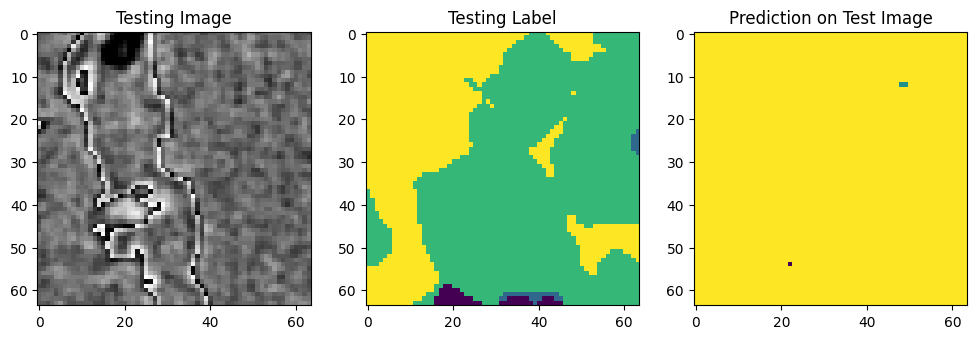

In [37]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title("Testing Image")
plt.imshow(test_img[slice,:,:], cmap='gray')
plt.subplot(232)
plt.title("Testing Label")
plt.imshow(ground_truth_idx[slice,:,:])
plt.subplot(233)
plt.title("Prediction on Test Image")
plt.imshow(test_prediction1[slice,:,:])
plt.show